In [1]:
# This file includes JuliaMBD from source codes directly.
# If JuliaMBD is installed from GitHub, please use the following codes:
#
# using Pkg
# Pkg.add(url="https://github.com/JuliaMBD/JuliaMBD.jl.git")
# using Plots
# using DifferentialEquations
# using JuliaMBD
# using JuliaMBD.Diagram

include("../src/JuliaMBD.jl")
using DifferentialEquations
using Plots
using .JuliaMBD
using .JuliaMBD.Diagram

In [4]:
@model DCMotorDisk begin
    @parameter begin
        R = 5.7
        L = 0.2
        K_e = 7.16e-2
        K_tau = 7.2e-2
        J_M = 1.1e-4
        J_I = 1.3e-3
        D = 6.0e-5
    end
    @xmlmodel("MBD.drawio", "DCMotorDisk")
end


DCMotorDisk (generic function with 1 method)

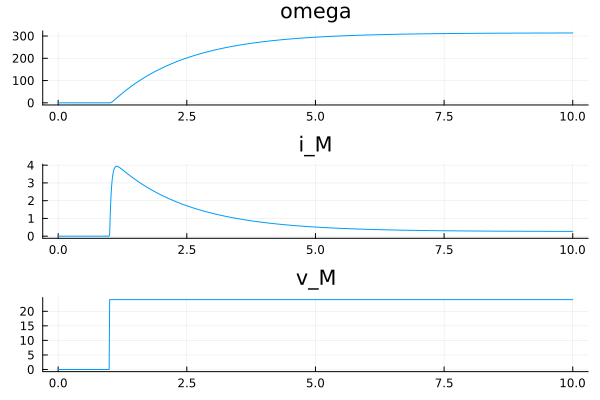

In [5]:
@model Test begin
    @block begin
        s = Step(steptime=1, finalvalue=24)
        m = DCMotorDisk()
    end
    @connect begin
        s.out => m.v_M
    end
    @scope begin
        m.omega => omega
        m.i_M => i_M
        m.v_M => v_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res)

In [6]:
@model Tachogenerator begin
    @parameter begin
        alpha_T = 1.5/1000
    end
    @xmlmodel("MBD.drawio", "Tachogenerator")
end

Tachogenerator (generic function with 1 method)

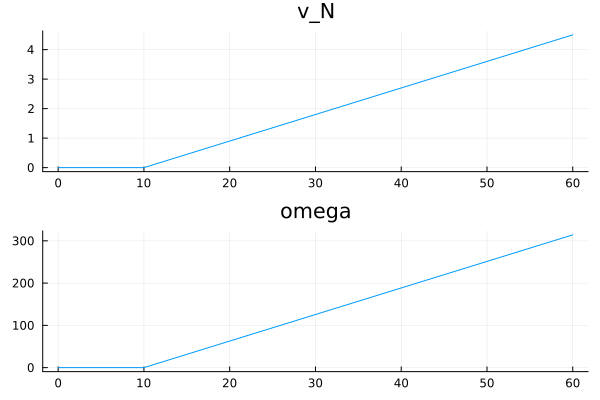

In [7]:
@model Test begin
    @parameter omega_d = 2*pi
    @block begin
        s = Ramp(slope=omega_d, starttime=10)
        m = Tachogenerator()
    end
    @connect begin
        s.out => m.omega
    end
    @scope begin
        m.v_N => v_N
        m.omega => omega
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

In [8]:
@model MotorDriver begin
    @parameter begin
        alpha_i = 5/37.5
    end
    @xmlmodel("MBD.drawio", "MotorDriver")
end

MotorDriver (generic function with 1 method)

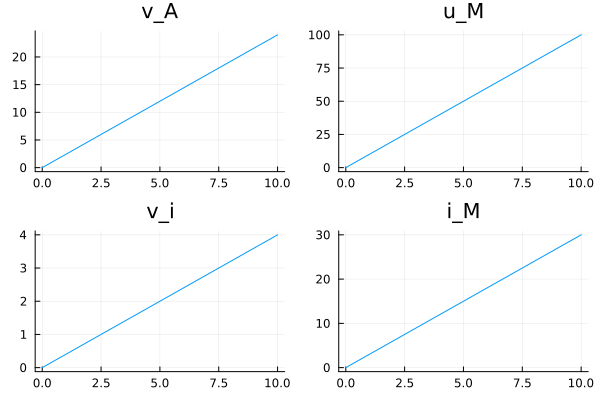

In [9]:
@model Test begin
    @parameter begin
        Vs = 24
        u_M_d = 10
        i_M_d = 3
    end
    @block begin
        s1 = Constant(value=Vs)
        s2 = Ramp(slope=u_M_d)
        s3 = Ramp(slope=i_M_d)
        m = MotorDriver()
    end
    @connect begin
        s1.out => m.Vs
        s2.out => m.u_M
        s3.out => m.i_M
    end
    @scope begin
        m.v_A => v_A
        m.u_M => u_M
        m.v_i => v_i
        m.i_M => i_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res, layout=(2,2))

In [10]:
@buildxml("models.xml", DCMotorDisk, Tachogenerator, MotorDriver)

6417

In [11]:
@model PlantModel begin
    @parameter begin
        Vs = 24
    end
    @xmlmodel("MBD.drawio", "PlantModel")
end

PlantModel (generic function with 1 method)

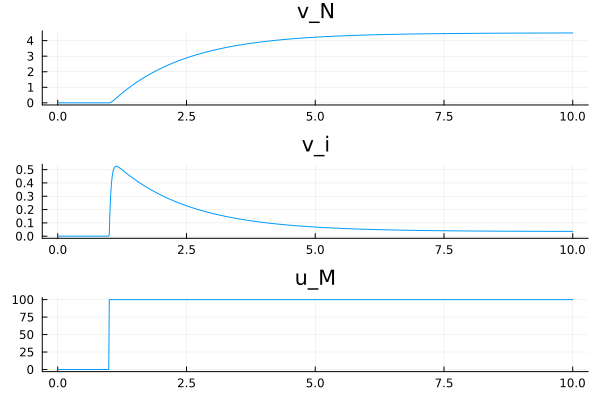

In [12]:
@model Test begin
    @parameter begin
        u_MD = 100
    end
    @block begin
        s1 = Step(steptime=1, finalvalue=u_MD)
        m = PlantModel()
    end
    @connect begin
        s1.out => m.u_M
    end
    @scope begin
        m.v_N => v_N
        m.v_i => v_i
        m.u_M => u_M
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,10))
plot(res)

In [13]:
@model ADConverter begin
    @parameter begin
        n = 10
        V_A_max = 5
        V_A_min = 0
        alpha_A = (2^n-1)/(V_A_max - V_A_min)
    end
    @xmlmodel("MBD.drawio", "ADConverter")
end

ADConverter (generic function with 1 method)

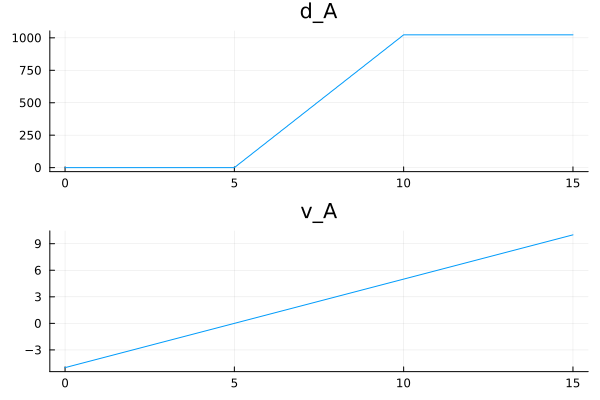

In [14]:
@model Test begin
    @parameter begin
        u_A_d = 1
    end
    @block begin
        s1 = Ramp(slope=u_A_d, starttime=0, initialoutput=-5)
        m = ADConverter()
    end
    @connect begin
        s1.out => m.v_A
    end
    @scope begin
        m.d_A => d_A
        m.v_A => v_A
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,15))
plot(res)

In [15]:
@model PulseGenerator2 begin
    @parameter begin
        m = 8
        alpha_P = 100/(2^m-1)
    end
    @xmlmodel("MBD.drawio", "PulseGenerator")
end

PulseGenerator2 (generic function with 1 method)

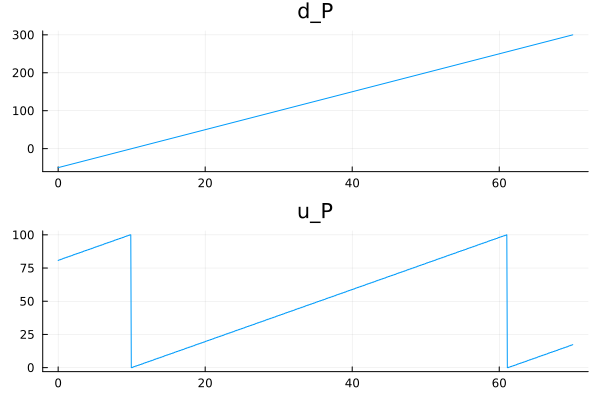

In [16]:
@model Test begin
    @parameter begin
        d_P_d = 5
    end
    @block begin
        s1 = Ramp(slope=d_P_d, starttime=0, initialoutput=-50)
        m = PulseGenerator2()
    end
    @connect begin
        s1.out => m.d_P
    end
    @scope begin
        m.d_P => d_P
        m.u_P => u_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,70))
plot(res)

In [17]:
@model Decoder begin
    @parameter begin
        alpha_T = 1.5/1000
        alpha_i = 5/37.5
        n = 10
        V_A_max = 5
        V_A_min = 0
        alpha_A = (2^n-1)/(V_A_max - V_A_min)
    end
    @xmlmodel("MBD.drawio", "Decoder")
end


Decoder (generic function with 1 method)

In [18]:
@model Encoder begin
    @parameter begin
        m = 8
        u_max = 100
        u_min = 0
    end
    @xmlmodel("MBD.drawio", "Encoder")
end


Encoder (generic function with 1 method)

In [19]:
@buildxml("models.xml", Decoder, Encoder)

4023

In [20]:
@model Controller begin
    @xmlmodel("MBD.drawio", "Controller")
end

Controller (generic function with 1 method)

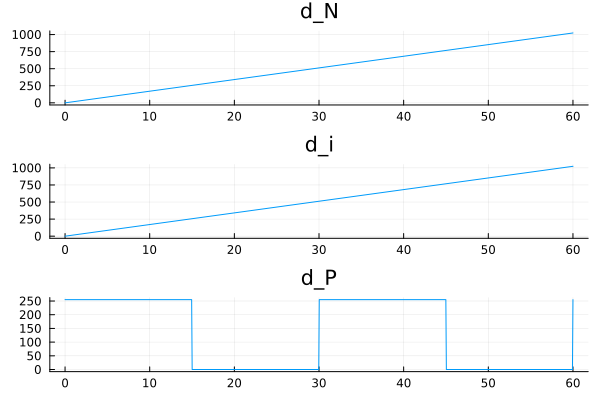

In [21]:
@model Test begin
    @parameter begin
        n = 10
        d_N_d = (2^n-1)/60
        d_i_d = (2^n-1)/60
    end
    @block begin
        ramp1 = Ramp(slope=d_N_d)
        ramp2 = Ramp(slope=d_i_d)
        c = Controller()
    end
    @connect begin
        ramp1.out => c.d_N
        ramp2.out => c.d_i
    end
    @scope begin
        c.d_N => d_N
        c.d_i => d_i
        c.d_P => d_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

In [22]:
@buildxml("models.xml", ADConverter)

1587

In [23]:
@model ADConverters begin
    @xmlmodel("MBD.drawio", "ADConverters")
end

ADConverters (generic function with 1 method)

In [24]:
@buildxml("models.xml", ADConverters, Controller, PulseGenerator2)

5872

In [25]:
@model ControllerModel begin
    @xmlmodel("MBD.drawio", "ControllerModel")
end

ControllerModel (generic function with 1 method)

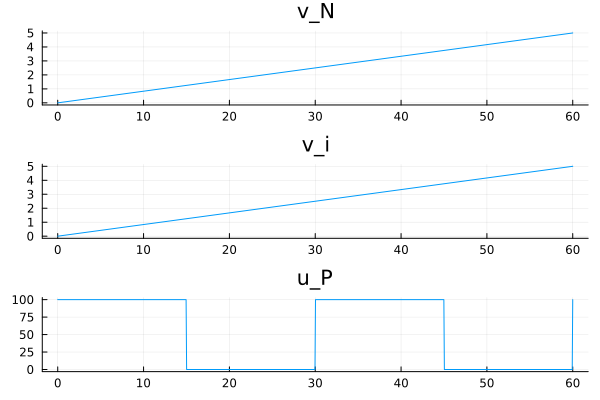

In [26]:
@model Test begin
    @parameter begin
        v_N_d = 5/60
        v_i_d = 5/60
    end
    @block begin
        ramp1 = Ramp(slope=v_N_d)
        ramp2 = Ramp(slope=v_i_d)
        c = ControllerModel()
    end
    @connect begin
        ramp1.out => c.v_N
        ramp2.out => c.v_i
    end
    @scope begin
        c.v_N => v_N
        c.v_i => v_i
        c.u_P => u_P
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res)

In [27]:
@buildxml("models.xml", PlantModel, ControllerModel)

3913

In [28]:
@model SystemModel begin
    @xmlmodel("MBD.drawio", "SystemModel")
end

SystemModel (generic function with 1 method)

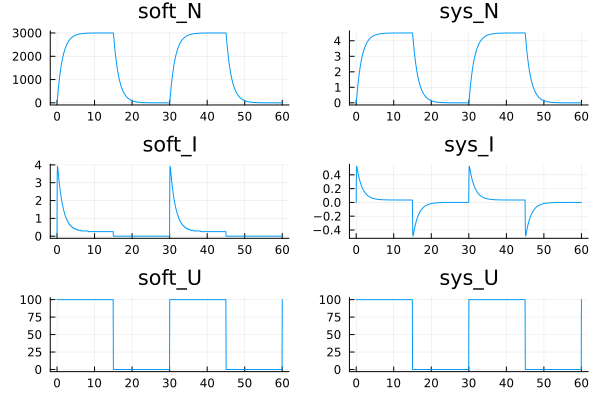

In [29]:
@model Test begin
    @block begin
        m = SystemModel()
        softn = From(tag=:soft_N)
        softi = From(tag=:soft_i)
        softu = From(tag=:soft_u)
        sysn = From(tag=:sys_N)
        sysi = From(tag=:sys_i)
        sysu = From(tag=:sys_u)
    end
    @scope begin
        softn.out => soft_N
        sysn.out => sys_N
        softi.out => soft_I
        sysi.out => sys_I
        softu.out => soft_U
        sysu.out => sys_U
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res, layout=(3,2))

In [30]:
@model PlantModel begin
    @parameter begin
        Vs = 24
    end
    @xmlmodel("MBD.drawio", "PlantModel2")
end

PlantModel (generic function with 1 method)

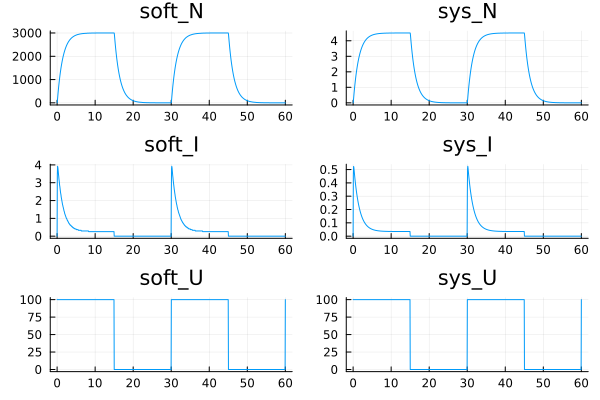

In [31]:
@model Test begin
    @block begin
        m = SystemModel()
        softn = From(tag=:soft_N)
        softi = From(tag=:soft_i)
        softu = From(tag=:soft_u)
        sysn = From(tag=:sys_N)
        sysi = From(tag=:sys_i)
        sysu = From(tag=:sys_u)
    end
    @scope begin
        softn.out => soft_N
        sysn.out => sys_N
        softi.out => soft_I
        sysi.out => sys_I
        softu.out => soft_U
        sysu.out => sys_U
    end
end

m = @compile Test()
res = simulate(m, tspan=(0,60))
plot(res, layout=(3,2))

In [32]:
@model PIDControl begin
    @parameter begin
        SV = 1000
        K_P = 0.1
        K_I = 0.05
        K_D = 0.01
        u_min = 0
        u_max = 100
    end
    @xmlmodel("MBD.drawio", "PIDControl")
end

PIDControl (generic function with 1 method)

In [33]:
@buildxml("models.xml", PIDControl)

1606

In [34]:
@model Controller begin
    @xmlmodel("MBD.drawio", "Controller2")
end

Controller (generic function with 1 method)

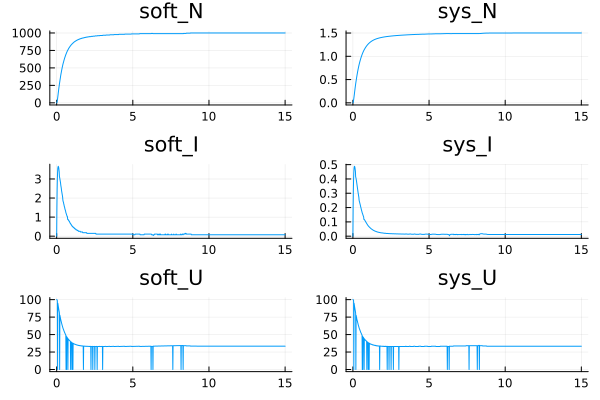

In [35]:
@model Test begin
    @block begin
        m = SystemModel()
        softn = From(tag=:soft_N)
        softi = From(tag=:soft_i)
        softu = From(tag=:soft_u)
        sysn = From(tag=:sys_N)
        sysi = From(tag=:sys_i)
        sysu = From(tag=:sys_u)
    end
    @scope begin
        softn.out => soft_N
        sysn.out => sys_N
        softi.out => soft_I
        sysi.out => sys_I
        softu.out => soft_U
        sysu.out => sys_U
    end
end

m = @compile_derivative Test()
res = simulate(m, tspan=(0,15))
plot(res, layout=(3,2))